<a href="https://colab.research.google.com/github/hsym-uec/myWeb_github/blob/main/Simmple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# SoftBank Stock data from Stooq.com 
# reference https://seanmemo.com/234/

from pandas_datareader import data
start = '2022-04-01'
end = '2023-05-31'
#9984:ソフトバンク
#df = data.DataReader('9984.JP', 'stooq', start, end)
#7832:バンナム
df = data.DataReader('7832.JP', 'stooq', start, end)

In [13]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-05-23,3424.00,3449.00,3381.00,3393.00,1.842800e+06
2023-05-22,3361.00,3409.00,3353.00,3400.00,1.501200e+06
2023-05-19,3388.00,3401.00,3364.00,3388.00,1.818600e+06
2023-05-18,3333.00,3363.00,3322.00,3337.00,1.891100e+06
2023-05-17,3278.00,3309.00,3273.00,3294.00,2.232000e+06
...,...,...,...,...,...
2022-04-07,9069.86,9227.40,9068.86,9176.55,5.489779e+05
2022-04-06,9106.75,9220.42,9066.87,9180.54,6.162713e+05
2022-04-05,9285.24,9315.15,9178.54,9245.35,4.842919e+05


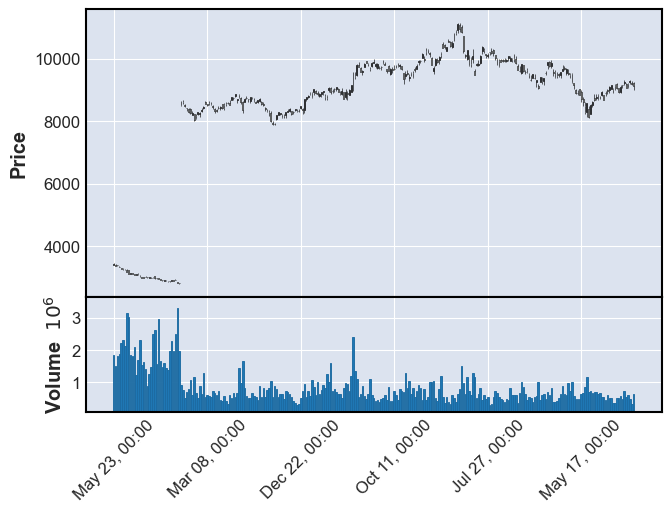

In [14]:
import mplfinance as mpf
mpf.plot(df, type='candle',volume=True)

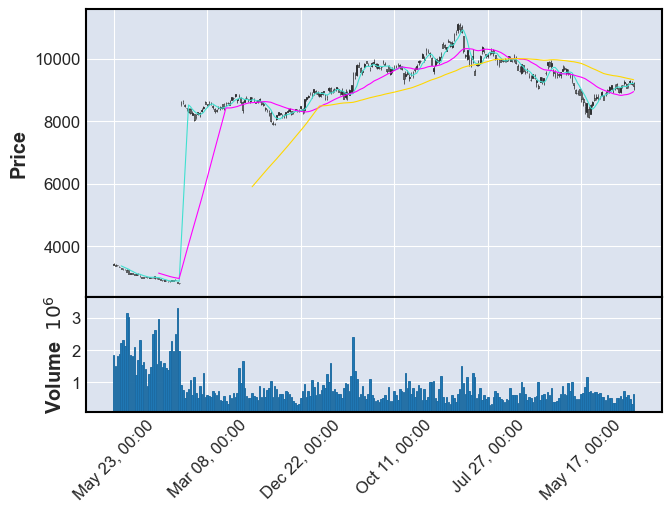

In [15]:
mpf.plot(df,type='candle',mav=(5,25,75),volume=True)